In [1]:
import os
import sys
import json
import time
import random
import datetime
import numpy as np
import pandas as pd
import sklearn.cluster as sklc
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def ct_expanded_rows(df):
    return len(df[df['fatalities'] == 0]) + df['fatalities'].sum()
    # because we will count each non-fatal incident once, and each
    # fatality as a separate point.

In [3]:
def expand_by_fatalities(df): # returns expanded dataframe    
    
    expanded_list = []
    for i, row in enumerate(df.iterrows()):
        fatalities = row[1]['fatalities']
        if fatalities > 0:
            expanded_list += [row[1].tolist()] * fatalities
        else:
            expanded_list += [row[1].tolist()]
    df_expanded = pd.DataFrame(expanded_list, columns=df.columns)
    print("Test passed: ", (len(df_expanded) == ct_expanded_rows(df)))
    print("Output dataframe has ", len(df_expanded), ' rows.')
    return df_expanded

In [4]:
# Normalize dataframe - note no return - operates on df in place
def normalize_df(df):
    df['event_datetime'] = pd.to_datetime(df['event_date'])
    df['latitude_norm'] = df['latitude'] - df['latitude'].min()
    df['longitude_norm'] = df['longitude'] - df['longitude'].min()
    df['event_day_num'] = df['event_datetime'] - df['event_datetime'].min()
    day_num_coeff = df['longitude_norm'].max()
    df['event_datetime_norm'] = (df['event_day_num'] / df['event_day_num'].max()) * day_num_coeff

In [5]:
df_raw = pd.read_csv('./data/1900-01-01-2018-12-20-Yemen.csv')

In [6]:
df_relevant = df_raw[['data_id', 'event_date', 'longitude', 'latitude', 'fatalities']]

In [7]:
normalize_df(df_relevant)
df_relevant_expanded = expand_by_fatalities(df_relevant)

/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Test passed:  True
Output dataframe has  79213  rows.


In [8]:
summary_stats = df_relevant_expanded.describe()
print(summary_stats)

            data_id     longitude      latitude    fatalities  latitude_norm  \
count  7.921300e+04  79213.000000  79213.000000  79213.000000   79213.000000   
mean   1.831174e+06     44.207203     14.958269     12.190436       2.640969   
std    2.720027e+05      0.985474      1.311613     18.178765       1.311613   
min    7.239640e+05     41.835300     12.317300      0.000000       0.000000   
25%    1.627070e+06     43.410300     13.611100      2.000000       1.293800   
50%    1.903717e+06     44.187000     14.815200     10.000000       2.497900   
75%    1.975357e+06     44.776900     16.164100     11.000000       3.846800   
max    2.351733e+06     54.022300     17.770000    155.000000       5.452700   

       longitude_norm             event_day_num  event_datetime_norm  
count    79213.000000                     79213         79213.000000  
mean         2.371903  612 days 02:14:58.670672             6.913426  
std          0.985474  314 days 01:12:51.715535             3.5471

In [9]:
def calc_kmeans(df, rangek):
    start = time.time()
    if type(rangek) is int:
        rangek = range(2,rangek + 1,3)
    
    df_tmp = df[['longitude_norm', 'latitude_norm', 'event_datetime_norm']]
    clusters = []
    for k in rangek:
        ktmp = sklc.KMeans(n_clusters=k).fit(df_tmp)
        silhouette_tmp = sklm.silhouette_score(df_tmp, ktmp.labels_)
        
        df['k' + str(k) + '_labels'] = ktmp.labels_
        clusters.append([k, ktmp.cluster_centers_, ktmp.inertia_, silhouette_tmp])
        print (k, 'out of', rangek, 'clusters analyzed.')
    
    df_clusters = pd.DataFrame(clusters, columns=['k', 'cluster_centers', 'sse', 'silhouette_score']).set_index('k')
    end = time.time()
    print('Analyzing', str(max(rangek)),' values of k took', end - start, 'seconds for this data with', len(df_tmp), 'observations.')
    return df.drop_duplicates(), df_clusters

In [12]:
df_sample = df_relevant_expanded.sample(frac=0.1)

In [17]:
df_analyzed, df_clusters = calc_kmeans(df_sample, 30)

2 out of range(2, 31, 3) clusters analyzed.
5 out of range(2, 31, 3) clusters analyzed.
8 out of range(2, 31, 3) clusters analyzed.
11 out of range(2, 31, 3) clusters analyzed.
14 out of range(2, 31, 3) clusters analyzed.
17 out of range(2, 31, 3) clusters analyzed.
20 out of range(2, 31, 3) clusters analyzed.
23 out of range(2, 31, 3) clusters analyzed.
26 out of range(2, 31, 3) clusters analyzed.
29 out of range(2, 31, 3) clusters analyzed.
Analyzing 29  values of k took 12.40408706665039 seconds for this data with 7921 observations.


In [21]:
df_clusters.head()

,cluster_centers,sse,silhouette_score
k,,,
2,"[[2.479236302827612, 2.55886546062633, 3.26914...",43559.788935,0.518514
5,"[[2.0290676850763854, 1.7803401880141, 10.6534...",23345.685288,0.291699
8,"[[2.3603748194014478, 3.7310542827657383, 3.29...",15922.829186,0.324536
11,"[[3.764445454545459, 2.174479157427938, 10.577...",12441.127679,0.329582
14,"[[2.5005552971576246, 1.0768604651162792, 1.11...",9939.530613,0.348537


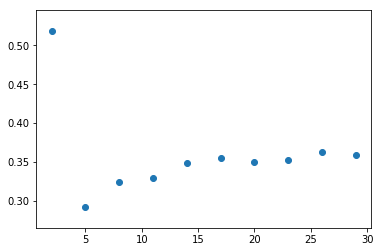

In [22]:
plt.scatter(df_clusters.index,df_clusters['silhouette_score'])

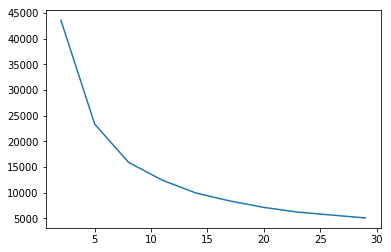

In [23]:
plt.plot(df_clusters['sse'])

In [26]:
df_clusters

,cluster_centers,sse,silhouette_score
k,,,
2,"[[2.479236302827612, 2.55886546062633, 3.26914...",43559.788935,0.518514
5,"[[2.0290676850763854, 1.7803401880141, 10.6534...",23345.685288,0.291699
8,"[[2.3603748194014478, 3.7310542827657383, 3.29...",15922.829186,0.324536
11,"[[3.764445454545459, 2.174479157427938, 10.577...",12441.127679,0.329582
14,"[[2.5005552971576246, 1.0768604651162792, 1.11...",9939.530613,0.348537
17,"[[2.91989239631337, 3.7343152073732733, 11.043...",8400.953194,0.355535
20,"[[2.911073853211015, 3.7623674311926623, 11.02...",7156.681332,0.349841
23,"[[2.0975498680738824, 1.065422955145118, 6.704...",6245.583284,0.352590
26,"[[2.729083333333338, 3.534274396135267, 7.7045...",5667.919571,0.362623


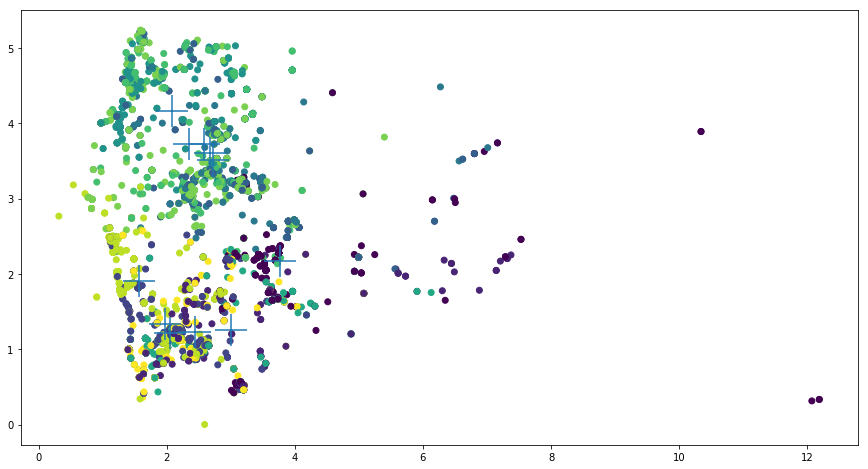

In [33]:
centers10 = df_clusters.iloc[3]['cluster_centers'][:]
plt.figure(figsize=(15,8))
# plt.subplot(211)
plt.scatter(df_analyzed['longitude_norm'], df_analyzed['latitude_norm'], c=df_analyzed['k11_labels'])
plt.scatter(centers10[:,0],centers10[:,1], marker='+', s=1000)
# plt.subplot(212)
# plt.scatter(df_analyzed['event_datetime_norm'], df_analyzed['latitude'], c=df_analyzed['k11_labels'])

(array([77., 41., 62., 38., 58., 42., 37., 10.,  5.,  3.]),
 array([735964. , 735997.5, 736031. , 736064.5, 736098. , 736131.5,
        736165. , 736198.5, 736232. , 736265.5, 736299. ]),
 <a list of 10 Patch objects>)

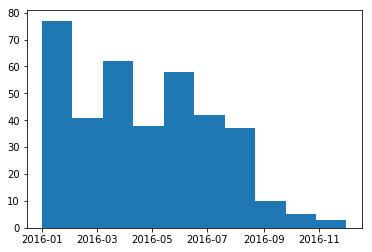

In [29]:
plt.hist(df_analyzed[df_analyzed['k11_labels'] == 1]['event_datetime'])

In [30]:
df_analyzed.describe()
df_clusters.describe()

,sse,silhouette_score
count,10.000000,10.000000
mean,13779.179185,0.359262
std,11878.958931,0.059895
min,5111.692771,0.291699
25%,6473.357796,0.334321
50%,9170.241904,0.351215
75%,15052.403809,0.358255
max,43559.788935,0.518514


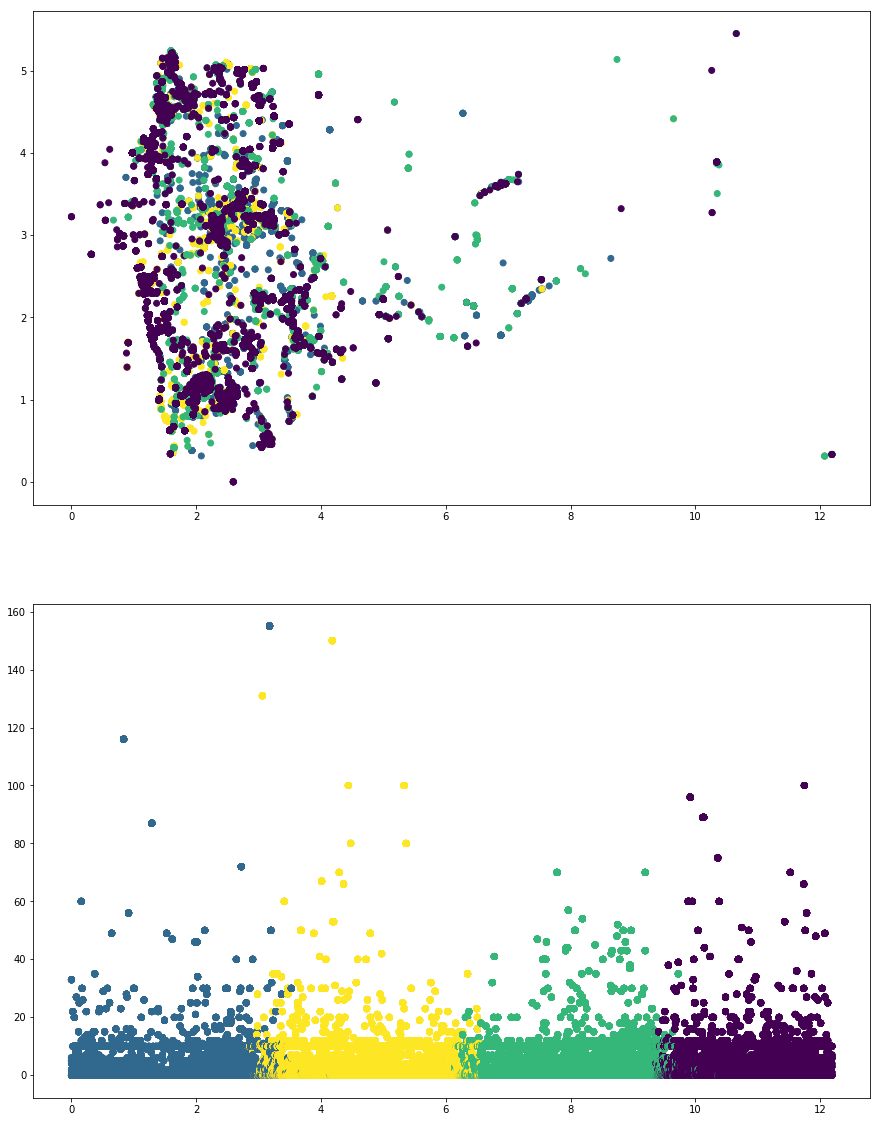

In [25]:
plt.figure(figsize=(15,20))
plt.subplot(211)
plt.scatter(df_relevant_expanded['longitude_norm'], df_relevant_expanded['latitude_norm'], c=df_relevant_expanded['k4_labels'])
plt.subplot(212)
plt.scatter(df_relevant_expanded['event_datetime_norm'], df_relevant_expanded['fatalities'], c=df_relevant_expanded['k4_labels'])

In [38]:
df_k_clusters['silhouette_score'].iloc[2:].argmax()

/Users/iv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


24

In [21]:
df

NameError: name 'df' is not defined